In [2]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
import matplotlib.pyplot as plt
from scipy.io import wavfile
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
IPython.display.Audio("../../../data/Berlin_data_emotional_speech/wav/03a01Fa.wav")

Loading data from berlin dataset...


c:\users\liu\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
c:\users\liu\appdata\local\programs\python\python35\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


(535,)


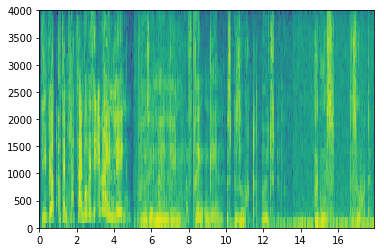

In [4]:
import itertools


path = "../../../data/Berlin_data_emotional_speech/wav/"
db_type = "berlin"
classes = {0:'W', 1:'L', 2:'E', 3:'A', 4:'F', 5:'T', 6:'N'}
males = ['03','10','11','12','15']
females = ['08','09','13','14','16']

def load_data():
    print("Loading data from " + db_type + " dataset...")
    inv_classes = {v: k for k, v in classes.items()}
    targets = [] 
    all_data = [] 
    train_sets = [] 
    test_sets = [] 
    get_data = True
    i = 0 
    train = [] 
    test = []
    xtrain = []
    ytrain = []
    max_tx = 0
    for audio in os.listdir(path):
        audio_path = os.path.join(path,audio)
        rate, data = get_wav_info(audio_path)
        all_data.append((data, rate))
        
        
        #print(rate)
        #print(data.shape)
        nfft = 200 # Length of each window segment
        fs = 8000 # Sampling frequencies
        noverlap = 120 # Overlap between windows
        nchannels = data.ndim
        if nchannels == 1:
            pxx, freqs, bins, im = plt.specgram(data, int(rate*0.005), fs, noverlap = rate*0.0025)
        elif nchannels == 2:
            pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
          
        
        x = pxx.swapaxes(0,1)
        if x.shape[0] > max_tx:
            max_tx = x.shape[0]
        
        xtrain.append(x)
        ytrain.append(inv_classes[audio[5]])
    
    return  xtrain, ytrain 
    #return (all_data, ytrain)
    
    
    #xtrain = np.array(xtrain)
    print(xtrain.shape)
    #print("xtrain shape", xtrain.shape)
    #print(xtrain)
    # print(set(ytrain))
    #ytrain = to_categorical(ytrain)
    #print(ytrain.shape)
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data   


xtrain,ytrain = load_data()  
ytrain = np.array(ytrain)
print(ytrain.shape)
#all_data, ytrain = load_data() 
#print(len(all_data))
#print(len(ytrain))

In [5]:
max_audio = 0
for i in xtrain:
    if i.shape[0] > max_audio:
        max_audio = i.shape[0]
for i, c in enumerate(xtrain) :
    diff = max_audio-c.shape[0]
    used_to_fill = np.zeros([diff, c.shape[1]])
    xtrain[i] = np.concatenate((c, used_to_fill))
print(max_audio)
print(xtrain[-1].shape)
xtrain = np.array(xtrain)
print(xtrain.shape)
ytrain = np.array(ytrain)
ytrain = to_categorical(ytrain)
print(ytrain.shape)

3590
(3590, 41)
(535, 3590, 41)
(535, 7)


In [6]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, LSTM
from keras.optimizers import Adam
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
import keras.backend as K

In [7]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [8]:
Tx = int((3590-15)/4 + 1)
print(Tx)
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

894


In [9]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(7, activation=softmax)

In [10]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([s_prev,a])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

In [11]:
def create_model(input_shape):
    X_input = Input(shape = input_shape)
    
    
    
    X = Conv1D(196, 15, strides=4, padding='valid')(X_input) # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    n_s = 64
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    a = Bidirectional(LSTM(units = 32, return_sequences = True))(X)
    for t in range(7):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        #out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        #outputs.append(out)
    
    #out = output_layer(s)
    
    out = output_layer(s)
    
    """
    X = Bidirectional(LSTM(units = 128, return_sequences = True))(X) # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    X = LSTM(units = 128, return_sequences = False)(X)  # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)  # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    X = Dense(7)(X)
    X = Activation('softmax')(X)
    """
    model = Model(inputs=[X_input, s0, c0], outputs=out)
    return model

In [12]:
input_shape = (xtrain.shape[1:])
print(xtrain.shape[1:])
model = create_model(input_shape)

(3590, 41)


In [13]:
opt = Adam(lr=0.00004, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [14]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(xtrain, ytrain, test_size=0.05, random_state=42)

s0 = np.zeros((X_train_.shape[0], n_s))
c0 = np.zeros((X_train_.shape[0], n_s))
vals0 = np.zeros((X_test_.shape[0], n_s))
valc0 = np.zeros((X_test_.shape[0], n_s))
"""
xtrain2 = xtrain[:500,:,:]
ytrain2 = ytrain[:500, :]
x_val = xtrain[500:,:,:]
y_val = ytrain[500:, :]
"""
model.fit([X_train_, s0, c0], y_train_, batch_size = 5, epochs=20, validation_data=([X_test_,vals0,valc0], y_test_))

Train on 508 samples, validate on 27 samples
Epoch 1/20
508/508 [==============================] - 59s 117ms/step - loss: 0.3508 - acc: 0.8659 - val_loss: 0.3374 - val_acc: 0.8624
Epoch 2/20
508/508 [==============================] - 52s 102ms/step - loss: 0.3048 - acc: 0.8757 - val_loss: 0.3244 - val_acc: 0.8624
Epoch 3/20
508/508 [==============================] - 52s 103ms/step - loss: 0.2962 - acc: 0.8808 - val_loss: 0.3357 - val_acc: 0.8624
Epoch 4/20
508/508 [==============================] - 52s 102ms/step - loss: 0.2805 - acc: 0.8850 - val_loss: 0.3471 - val_acc: 0.8519
Epoch 5/20
508/508 [==============================] - 52s 102ms/step - loss: 0.2741 - acc: 0.8819 - val_loss: 0.2978 - val_acc: 0.8624
Epoch 6/20
508/508 [==============================] - 55s 108ms/step - loss: 0.2628 - acc: 0.8855 - val_loss: 0.3394 - val_acc: 0.8624
Epoch 7/20
508/508 [==============================] - 55s 108ms/step - loss: 0.2546 - acc: 0.8875 - val_loss: 0.3353 - val_acc: 0.8466
Epoch 8/20

In [15]:
model.save("emotion_reco_val_0.9259_model.h5")

c:\users\liu\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 's0:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'c0:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
c:\users\liu\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/TensorArrayReadV3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
c:\users\liu\appdata\local\programs\python\python35\lib\site-pack

In [53]:
model.evaluate([x_val, s0, c0], y_val, verbose=1)

535/535 [==============================] - 11s 20ms/step


[0.1944428732740545, 0.9193591865423684]

In [62]:
model.evaluate([x_val, vals0, valc0], y_val, verbose=1)

35/35 [==============================] - 1s 19ms/step


[0.2808578554008688, 0.8938776288713728]

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 3590, 41)     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 894, 196)     120736      input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 894, 196)     784         conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 894, 196)     0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
s0 (InputL

In [96]:
shape1 = []
for i in xtrain:
    shape1.append(i.shape[1])
print(set(shape1))

{41}


In [84]:
max_audio = 0

x = all_data
xtrain = []
for i, data in enumerate(x[:]) :
    #print(data[0].shape[0])
    if data[0].shape[0] > max_audio:
        max_audio = data[0].shape[0]
for i in range(len(x[:])):
    diff = max_audio - x[i][0].shape[0]
    if diff>0:
        #used_to_fill = x[i][0][:diff]
        #concat_ = np.concatenate((x[i][0], used_to_fill))
        used_to_fill = np.zeros([diff], dtype=int)
        concat_ = np.concatenate((x[i][0], used_to_fill))
        xtrain.append(concat_)
        #print(xtrain[-1].shape)
    else:
        xtrain.append(x[i][0])
        #print(xtrain[-1].shape)
print()
print(max_audio)
xtrain = np.array(xtrain)
#xtrain = xtrain.reshape([xtrain.shape[1], xtrain.shape[2]])
ytrain = np.array(ytrain)
ytrain = to_categorical(ytrain)
print(xtrain.shape)
print(ytrain.shape)


143652
(535, 143652)
(535, 7)


In [88]:
# pxx, freqs, bins, im = plt.specgram(data, int(rate*0.005), fs, noverlap = rate*0.0025)
"""
for x_ in xtrain[:1]:
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = x_.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)


    x = pxx.swapaxes(0,1)
"""
print(xtrain[0].shape)

(143652,)


In [8]:
import itertools
males = ['03','10','11','12','15']
females = ['08','09','13','14','16']
list(itertools.product(males,females))

[('03', '08'),
 ('03', '09'),
 ('03', '13'),
 ('03', '14'),
 ('03', '16'),
 ('10', '08'),
 ('10', '09'),
 ('10', '13'),
 ('10', '14'),
 ('10', '16'),
 ('11', '08'),
 ('11', '09'),
 ('11', '13'),
 ('11', '14'),
 ('11', '16'),
 ('12', '08'),
 ('12', '09'),
 ('12', '13'),
 ('12', '14'),
 ('12', '16'),
 ('15', '08'),
 ('15', '09'),
 ('15', '13'),
 ('15', '14'),
 ('15', '16')]